<a href="https://colab.research.google.com/github/icecore013/image-segmentation-keras/blob/master/3_model_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective of the notebook

The aim of this code is to apply the trained model on some new test images.

This logic could be implemented on a production web application.

# Import and configuration variables

In [ ]:
# Loading of our drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'

Mounted at /content/gdrive


In [ ]:
# Installing and importing the desired packages
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Test')
from os import path as op
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
!pip install keras

!pip install tifffile
import tifffile

!pip install patchify
from patchify import patchify, unpatchify

!pip install rasterio
import rasterio

from smooth_blending import predict_img_with_smooth_windowing
from unet_model import simple_unet_model

     |████████████████████████████████| 19.3 MB 1.1 MB/s 


In [ ]:
# Setting the config variables

PREDICTION_IMAGE_PATH = '/content/gdrive/MyDrive/Data/Test_data/images'
PREDICTION_MASK_PATH = '/content/gdrive/MyDrive/Data/Test_data/masks'

PREDICTION_THRESHOLD = 0.5

IMAGE_SCALING_FACTOR = 10000
MASK_SCALING_FACTOR = 255

PATCH_SIZE = 256

IMG_CHANNELS = 5
MASK_CHANNELS = 1

# Retrieving the trained model

In [ ]:
# Loading a pre-trained model
model = simple_unet_model(PATCH_SIZE, PATCH_SIZE, IMG_CHANNELS)
model.load_weights('/content/gdrive/MyDrive/Data/model_save/model_patches_20220114.hdf5')

In [ ]:
# Displaying the architecture of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  736         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

# Applying the model on several patches of a large image

In [ ]:
# Applying the model on patches without smooth blending
total_Flist = sorted(os.listdir(PREDICTION_IMAGE_PATH))         # Listing all filenames in the prediction folder

predicted_images_bucket = []                                    # Initialisation of the prediction image bucket
large_image_bucket = []

for i, filename in enumerate(total_Flist):

  with rasterio.open(op.join(PREDICTION_IMAGE_PATH, filename), 'r') as ds:
    arr = ds.read()                                             # Lecture du fichier tiff et conversion en Array

  arr = arr / IMAGE_SCALING_FACTOR                              # Normalize the data (divide par 10000)
  large_image = np.moveaxis(arr, 0, -1)                         # Change dimension order (number of channel at the end)
  large_image_bucket.append(large_image)

  print(large_image.shape, i, filename)                         # Check the dimensions of the Array

  if large_image.shape[0] > PATCH_SIZE and large_image.shape[1] > PATCH_SIZE:    # Only big enough images
      
      SIZE_X = (large_image.shape[0]//PATCH_SIZE)*PATCH_SIZE                     # Nearest size divisible by our patch size
      SIZE_Y = (large_image.shape[1]//PATCH_SIZE)*PATCH_SIZE                     # Nearest size divisible by our patch size
      cropped_image = large_image[:SIZE_X, :SIZE_Y, :]                           # Crop the images to get a multiple of patches

      patches = patchify(cropped_image, (PATCH_SIZE, PATCH_SIZE, IMG_CHANNELS), step=PATCH_SIZE)  # Patchify the large image

      predicted_patches = []
      for i in range(patches.shape[0]):
          for j in range(patches.shape[1]):

              single_patch = patches[i,j,:,:,:,:]
              single_patch_prediction = (model.predict(single_patch))             # Applying the model on a single patch
              predicted_patches.append(single_patch_prediction)

      predicted_patches = np.array(predicted_patches)

      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 1, PATCH_SIZE, PATCH_SIZE, MASK_CHANNELS) )
      reconstructed_image = unpatchify(predicted_patches_reshaped, (cropped_image.shape[0], cropped_image.shape[1], MASK_CHANNELS))

      predicted_images_bucket.append(reconstructed_image)                        # Adding the reconstructed image to the prediction image bucket

(674, 959, 5) 0 CAL_database_Sentinel2_185_postFire_RGBIR.tif


In [ ]:
# Applying the model on patches with smooth blending
total_Flist = sorted(os.listdir(PREDICTION_IMAGE_PATH))         # Listing all filenames in the prediction folder

smooth_predicted_images_bucket = []                             # Initialisation of the prediction image bucket
cropped_image_bucket = []                                       # Initialisation of the cropped image bucket

for i, filename in enumerate(total_Flist):

  with rasterio.open(op.join(PREDICTION_IMAGE_PATH, filename), 'r') as ds:
    arr = ds.read()                                             # Lecture du fichier tiff et conversion en Array

  arr = arr / IMAGE_SCALING_FACTOR                              # Normalize the data (divide par 10000)
  large_image = np.moveaxis(arr, 0, -1)                         # Change dimension order (number of channel at the end)

  print(large_image.shape, i, filename)                         # Check the dimensions of the Array

  predictions_smooth = predict_img_with_smooth_windowing(
    large_image,
    window_size=PATCH_SIZE,
    subdivisions=2,                                             # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=1,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
  )

  smooth_predicted_images_bucket.append(predictions_smooth)

(674, 959, 5) 0 CAL_database_Sentinel2_185_postFire_RGBIR.tif


100%|██████████| 8/8 [01:25<00:00, 10.71s/it]


In [ ]:
# Collecting the masks that are used for comparison and as a target baseline
mask_Flist = sorted(os.listdir(PREDICTION_MASK_PATH))         # Listing all filenames in the prediction folder

mask_bucket = []                                              # Initialisation of the cropped image bucket

for i, filename in enumerate(mask_Flist):

  with rasterio.open(op.join(PREDICTION_MASK_PATH, filename), 'r') as ds:
    arr = ds.read()                                           # Lecture du fichier tiff et conversion en Array

  arr = arr / MASK_SCALING_FACTOR                             # Normalize the data (divide par 10000)
  large_mask = np.moveaxis(arr, 0, -1)                        # Change dimension order (number of channel at the end)

  print(large_mask.shape, i, filename)                        # Check the dimensions of the Array

  mask_bucket.append(large_mask)

(674, 959, 1) 0 CAL_database_Sentinel2_185_postFire_label.tif


# Visualizing the predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


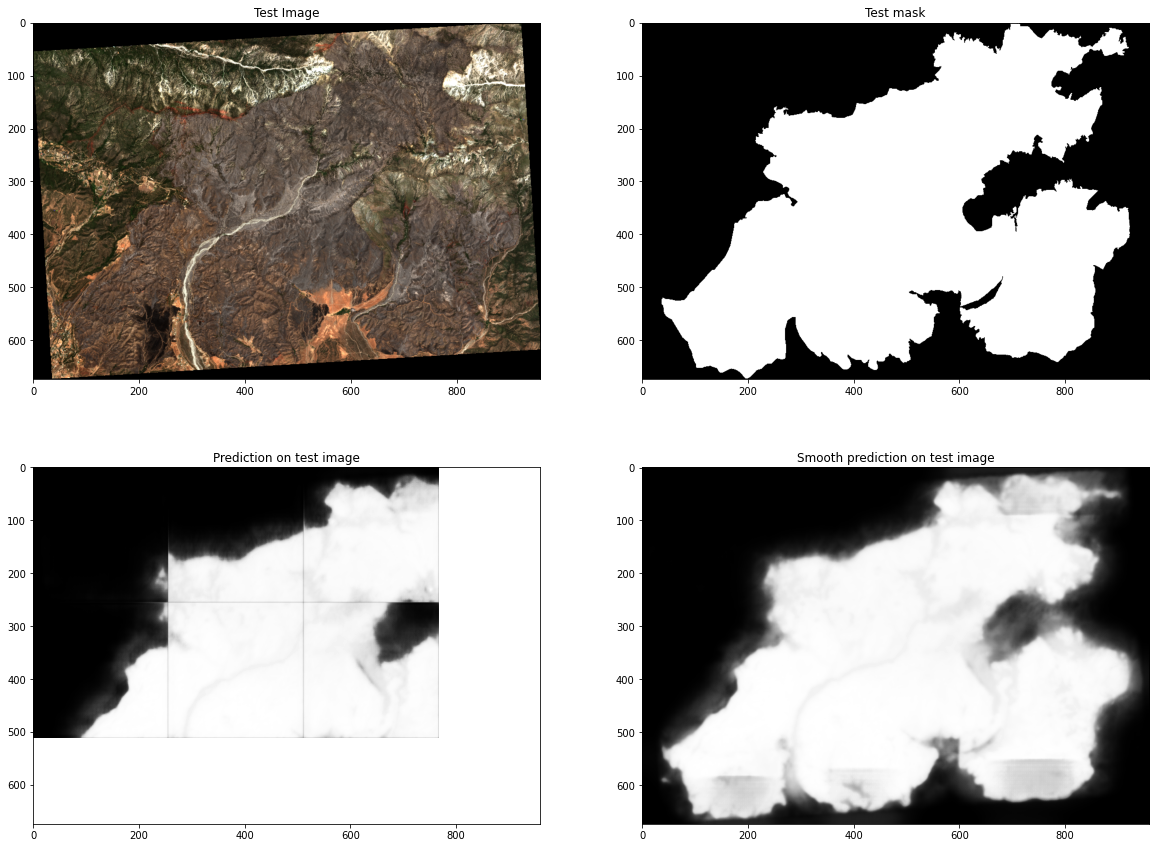

In [ ]:
# Visualizing the prediction results
for large_image, mask, predicted_image, smooth_predicted_image in zip(large_image_bucket, 
                                                                      mask_bucket,
                                                                      predicted_images_bucket,
                                                                      smooth_predicted_images_bucket):
  
  test_img = large_image[:, :, :3]                                      # Limiting to RGB for visual check
  test_img_rgb = test_img[:, :, ::-1] * 4
  
  test_mask = mask[:, :, 0]

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))   # Creating a Figure with subplots
  
  ax1.imshow(test_img_rgb)                                              # Showing the test image
  ax1.set_title('Test Image')
  #ax1.axis('off')

  ax2.imshow(test_mask, cmap='gray')                                    # Showing the test mask
  ax2.set_title('Test mask')
  #ax2.axis('off')  

  ax3.imshow(predicted_image[:, :, 0], cmap='gray')                     # Showing the prediction image without smooth blending
  ax3.set_title('Prediction on test image')
  ax3.set_xlim(0, large_image.shape[1])                                 # Changing x and y lim because the image has been cropped
  ax3.set_ylim(large_image.shape[0], 0)
  #ax3.axis('off')

  ax4.imshow(smooth_predicted_image[:, :, 0], cmap='gray')              # Showing the smoothed prediction image
  ax4.set_title('Smooth prediction on test image')
  #ax4.axis('off')